In [2]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
plt.rcParams['figure.facecolor'] = 'white'
import matplotlib.colors as colors
import cmocean.cm as cmo
from glob import glob
#import xgcm

In [2]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 31.36 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33631,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 31.36 GiB
Comm: tcp://127.0.0.1:35545,Total threads: 1
Dashboard: http://127.0.0.1:38293/status,Memory: 7.84 GiB
Nanny: tcp://127.0.0.1:36969,


In [3]:
import datetime
import nc_time_axis

In [4]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import cartopy
import matplotlib.path as mpath

In [5]:
PVORT_data_filesREF = "/data0/project/drakkar/USERS/jrieck/CREG12.L75-REF08-PVORT/1996/*PVORT.nc"
PVORT_data_filesFUT = "/data0/project/drakkar/USERS/jrieck/CREG12.L75-FUT08-PVORT/2051/*PVORT.nc"

grid_files = "/data0/project/drakkar/CONFIGS/CREG12.L75/GRID/CREG12.L75-REF08_mesh_hgr.nc"
coords_file = "/data0/project/drakkar/CONFIGS/CREG12.L75/GRID/coordinates_CREG12_lbclnk_noz_vh20160930.nc"
mask_file= "/data0/project/drakkar/CONFIGS/CREG12.L75/GRID/CREG12.L75-REF08_mask.nc"
# bathy_file = "/data0/project/drakkar/CONFIGS/CREG12.L75/GRID/bathymetry_CREG12_V3.3_CT20180612Larger_ct20190102.nc"

In [6]:
def prepro(ds):
    return ds.isel(y=slice(800, None))

In [237]:
grid = xr.open_mfdataset(grid_files, parallel=True, preprocess=prepro)
coordsCREG = xr.open_mfdataset(coords_file, parallel=True, preprocess=prepro)
mask = xr.open_mfdataset(mask_file, parallel=True, preprocess=prepro)

In [8]:
PVORT_REF = xr.decode_cf(xr.open_mfdataset(PVORT_data_filesREF, coords="minimal", compat="override", parallel=True, decode_cf=False,
                                       preprocess=prepro, chunks={"deptht": 1, "y": 600, "x": 800}))

PVORT_REF = PVORT_REF.assign_coords({"nav_lon":grid.nav_lon,"nav_lat":grid.nav_lat})

In [9]:
PVORT_FUT = xr.decode_cf(xr.open_mfdataset(PVORT_data_filesFUT, coords="minimal", compat="override", parallel=True, decode_cf=False,
                                       preprocess=prepro, chunks={"deptht": 1, "y": 600, "x": 800}))

PVORT_FUT = PVORT_FUT.assign_coords({"nav_lon":grid.nav_lon,"nav_lat":grid.nav_lat})

[None, None, None]

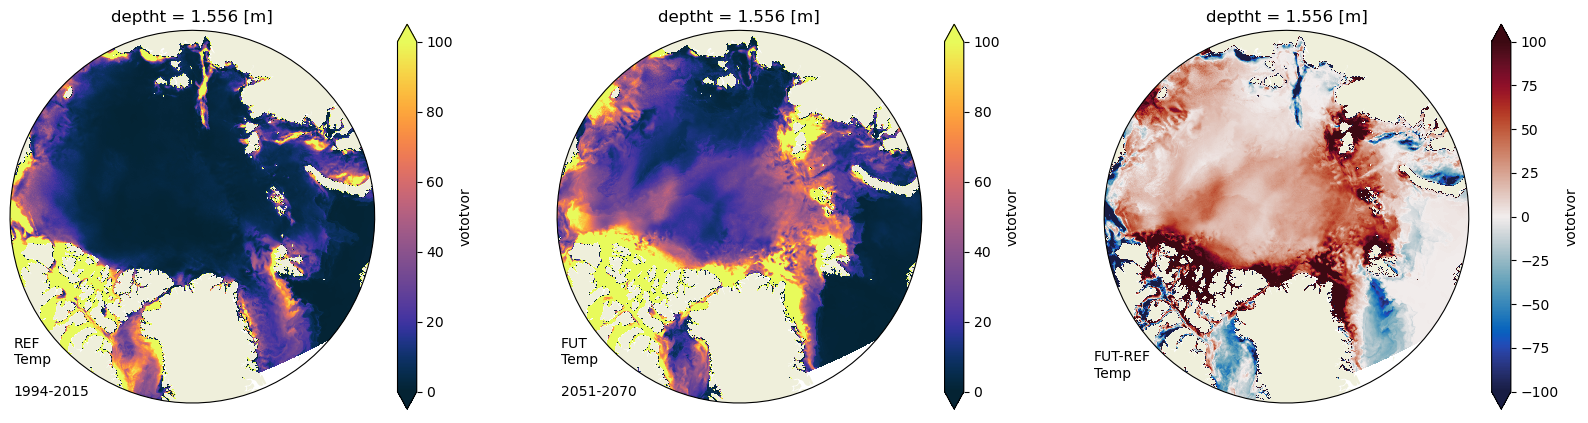

In [104]:
fig = plt.figure(figsize=(20, 5))

ax1 = fig.add_subplot(1, 3, 1, projection=ccrs.NorthPolarStereo(-45))
ax2 = fig.add_subplot(1, 3, 2, projection=ccrs.NorthPolarStereo(-45))
ax3 = fig.add_subplot(1, 3, 3, projection=ccrs.NorthPolarStereo(-45))

PVORT_ref = PVORT_REF.vototvor.mean('time_counter').isel(deptht=1)
PVORT_ref.plot(x='nav_lon',y='nav_lat',vmin=0, vmax=100, cmap=cmo.thermal, ax=ax1, transform=ccrs.PlateCarree(),rasterized=True)
PVORT_fut = PVORT_FUT.vototvor.mean('time_counter').isel(deptht=1)
PVORT_fut.plot(x='nav_lon',y='nav_lat',vmin=0, vmax=100, cmap=cmo.thermal, ax=ax2, transform=ccrs.PlateCarree(),rasterized=True)

(PVORT_fut-PVORT_ref).plot(x='nav_lon',y='nav_lat',vmin=-100, vmax=100, cmap=cmo.balance, ax=ax3, transform=ccrs.PlateCarree(),rasterized=True)

ax1.text(-90, 63, "REF\nTemp\n\n1994-2015", transform=ccrs.PlateCarree())
ax2.text(-90, 63, "FUT\nTemp\n\n2051-2070", transform=ccrs.PlateCarree())
ax3.text(-90, 61, "FUT-REF\nTemp\n\n", transform=ccrs.PlateCarree())

[map_config(ax) for ax in [ax1,ax2,ax3]]
# plt.savefig("figures/CREG12.L75_KE_REF08_2000-2009_vs_FUT08_2060-2069_k00_moorings_bathy.v2.png", dpi=300)

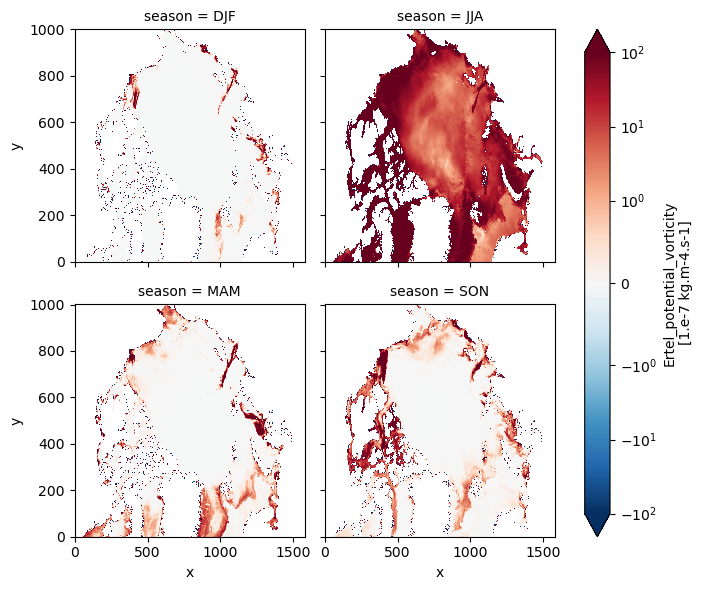

In [10]:
PVORT_REF.vototvor.groupby('time_counter.season').mean().isel(deptht=1).plot(col="season", col_wrap=2, norm=colors.SymLogNorm(linthresh=1, linscale=1,
                                              vmin=-1e2, vmax=1e2, base=10))

In [10]:
from scipy import spatial

def transform_coordinates(coords):
    """Transform coordinates to cartesian

    Parameters
    ----------
    coords : array
        Numpy array of shape=(n, 2). First column is latitudes, second column
        is longitudes.
        `array([[lat_1, lon_1], [lat_2, lon_2], ..., [lat_n, lon_n]])`

    Returns
    -------
    X : array
        Numpy array of shape=(n, 2) containing the cartesian coordinates
        corresponding to `coords`.

    """
    # WGS 84 reference coordinate system parameters
    A = 6378.137  # major axis [km]
    E2 = 6.69437999014e-3  # eccentricity squared

    coords = np.asarray(coords).astype(float)

    # convert to radiants
    lat_rad = np.radians(coords[:, 0])
    lon_rad = np.radians(coords[:, 1])

    # convert to cartesian coordinates
    r_n = A / (np.sqrt(1 - E2 * (np.sin(lat_rad) ** 2)))
    x = r_n * np.cos(lat_rad) * np.cos(lon_rad)
    y = r_n * np.cos(lat_rad) * np.sin(lon_rad)
    z = r_n * (1 - E2) * np.sin(lat_rad)

    return np.column_stack((x, y, z))

In [287]:
A = 6378.137  # major axis [km]
E2 = 6.69437999014e-3  # eccentricity squared

lat_rad = np.radians(89) #(coords[:, 0])
lon_rad = np.radians(-150) #(coords[:, 1])

r_n = A / (np.sqrt(1 - E2 * (np.sin(lat_rad) ** 2)))
x = r_n * np.cos(lat_rad) * np.cos(lon_rad)
y = r_n * np.cos(lat_rad) * np.sin(lon_rad)
z = r_n * (1 - E2) * np.sin(lat_rad)

In [289]:
y

-55.844097177867695

In [257]:
data = PVORT_FUT

coords = np.column_stack((coordsCREG["glamt"].values.ravel(),
                          coordsCREG["gphit"].values.ravel()))
# construct KD-tree
#tree = spatial.cKDTree(transform_coordinates(coords))
tree = spatial.cKDTree(coords)

/opt/linux/envs/envs/phyocean-2021.05/lib/python3.8/site-packages/xarray/core/indexing.py:1375: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


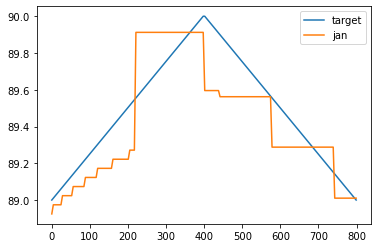

In [258]:
sec1_len = 100
sec2_len = 100

lon_points = np.hstack((np.ones(sec1_len) * -150, np.ones(sec2_len) * -10))
lat_points = np.hstack((np.linspace(89, 90, sec1_len), np.linspace(90, 89, sec2_len)))
points = np.column_stack((lon_points, lat_points))

data_shape = data["nav_lat"].squeeze().shape

#_, index = tree.query(transform_coordinates(points))
_, index = tree.query(points)

# regrid to 2D grid
index = np.unravel_index(index, data_shape)

x_index = index[1]
y_index = index[0]

x_i = x_index 
y_i = y_index 

ds_xi = xr.DataArray(x_i, dims=["x_points"])
ds_yi = xr.DataArray(y_i, dims=["y_points"])

transect_REF = PVORT_REF.assign_coords({"x":PVORT_REF.x,"y":PVORT_REF.y}).sel(x=ds_xi,y=ds_yi,method='nearest')

diag = xr.DataArray(np.arange(sec1_len + sec2_len), dims="diag")
diag_transect_REF = transect_REF.isel(x_points=diag, y_points=diag)

lat_points_ja = diag_transect_REF.nav_lat.compute()

plt.plot(np.linspace(0, 799, sec1_len + sec2_len), lat_points, label="target")
plt.plot(np.linspace(0, 799, sec1_len + sec2_len), lat_points_ja, label="jan")
#plt.plot(lat_points_jo, label="josue")
#plt.xlim(350, 450)
#plt.ylim(85, 91)
plt.legend()

In [150]:
sec1_len = 400
sec2_len = 400

In [244]:
lon_points = np.hstack((np.ones(sec1_len) * -150, np.ones(sec2_len) * -10))
lat_points = np.hstack((np.linspace(70, 90, sec1_len), np.linspace(90, 75, sec2_len)))
points = np.column_stack((lon_points, lat_points))

data_shape = data["nav_lat"].squeeze().shape

In [245]:
_, index = tree.query(transform_coordinates(points))

# regrid to 2D grid
index = np.unravel_index(index, data_shape)

x_index = index[1]
y_index = index[0]

In [246]:
x_0 = np.linspace(500,850,400)
y_0 = np.linspace(840,455,400)

x_1 = np.linspace(850,900,400)
y_1 = np.linspace(455,70,400)

In [247]:
x_i = x_index 
#x_i = np.hstack((x_0,x_1))
y_i = y_index 
#y_i = np.hstack((y_0,y_1))

In [248]:
ds_xi = xr.DataArray(x_i, dims=["x_points"])
ds_yi = xr.DataArray(y_i, dims=["y_points"])

In [249]:
transect_REF = PVORT_REF.assign_coords({"x":PVORT_REF.x,"y":PVORT_REF.y}).sel(x=ds_xi,y=ds_yi,method='nearest')
transect_FUT = PVORT_FUT.assign_coords({"x":PVORT_REF.x,"y":PVORT_REF.y}).sel(x=ds_xi,y=ds_yi,method='nearest')

/opt/linux/envs/envs/phyocean-2021.05/lib/python3.8/site-packages/xarray/core/indexing.py:1375: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


In [250]:
diag = xr.DataArray(np.arange(sec1_len + sec2_len), dims="diag")
diag_transect_REF = transect_REF.isel(x_points=diag, y_points=diag)
diag_transect_FUT = transect_FUT.isel(x_points=diag, y_points=diag)

In [251]:
#lat_points_jo = diag_transect_REF.nav_lat.compute()
lat_points_ja = diag_transect_REF.nav_lat.compute()

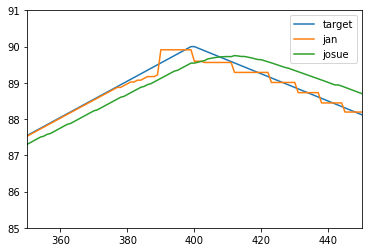

In [252]:
plt.plot(np.linspace(0, 799, sec1_len + sec2_len), lat_points, label="target")
plt.plot(np.linspace(0, 799, sec1_len + sec2_len), lat_points_ja, label="jan")
plt.plot(lat_points_jo, label="josue")
plt.xlim(350, 450)
plt.ylim(85, 91)
plt.legend()

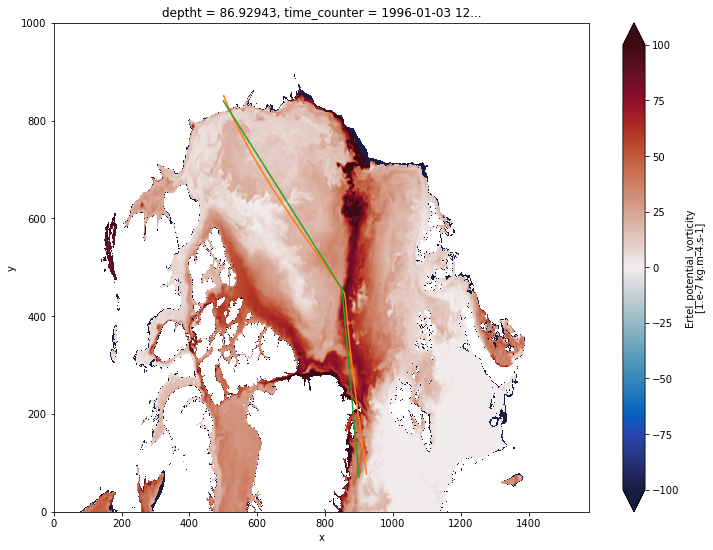

In [201]:
fig = plt.figure(figsize=(12, 9))
PVORT_REF.vototvor.isel(time_counter=0).sel(deptht=90, method="nearest").plot(vmin=-1e2, vmax=1e2, cmap=cmo.balance)
plt.plot(x_index, y_index, color="tab:orange")
plt.plot(np.hstack((x_0,x_1)), np.hstack((y_0,y_1)), color="tab:green")

(430.0, 470.0)

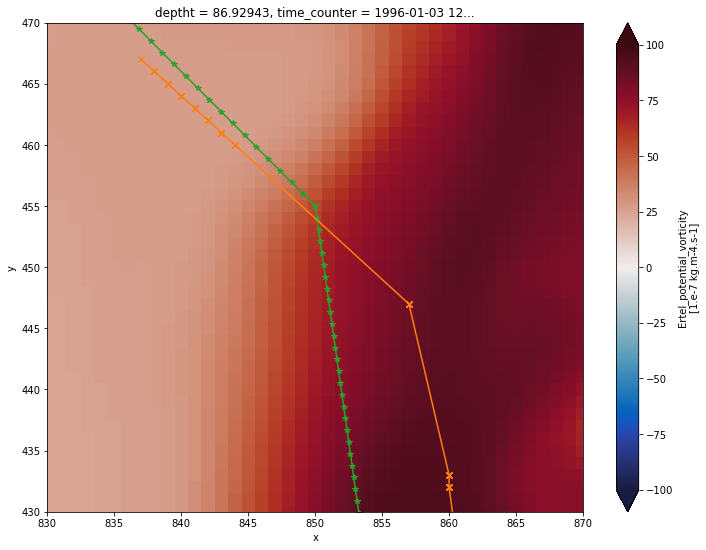

In [260]:
fig = plt.figure(figsize=(12, 9))
PVORT_REF.vototvor.isel(time_counter=0).sel(deptht=90, method="nearest").plot(vmin=-1e2, vmax=1e2, cmap=cmo.balance)
plt.plot(np.hstack((x_0,x_1)), np.hstack((y_0,y_1)), color="tab:green", marker="*")
plt.plot(x_index, y_index, color="tab:orange", marker="x")
plt.xlim(830, 870)
plt.ylim(430, 470)

(430.0, 470.0)

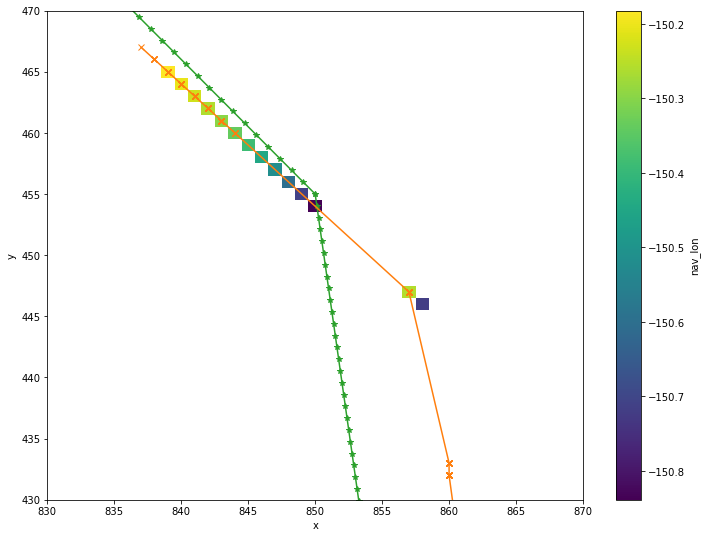

In [278]:
fig = plt.figure(figsize=(12, 9))
PVORT_REF.nav_lon.where(((PVORT_REF.nav_lon < -149) & (PVORT_REF.nav_lon > -151)
                        & (PVORT_REF.nav_lat > 89))).plot()
plt.plot(np.hstack((x_0,x_1)), np.hstack((y_0,y_1)), color="tab:green", marker="*")
plt.plot(x_index, y_index, color="tab:orange", marker="x")
plt.xlim(830, 870)
plt.ylim(430, 470)

(430.0, 470.0)

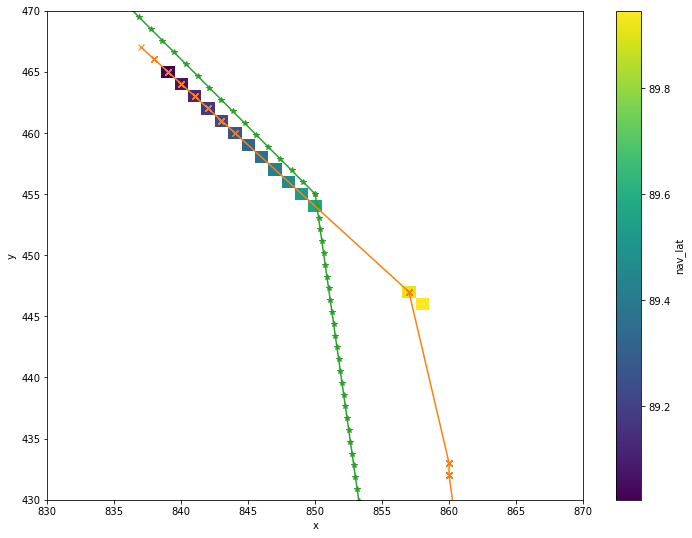

In [277]:
fig = plt.figure(figsize=(12, 9))
PVORT_REF.nav_lat.where(((PVORT_REF.nav_lon < -149) & (PVORT_REF.nav_lon > -151)
                        & (PVORT_REF.nav_lat > 89))).plot()
plt.plot(np.hstack((x_0,x_1)), np.hstack((y_0,y_1)), color="tab:green", marker="*")
plt.plot(x_index, y_index, color="tab:orange", marker="x")
plt.xlim(830, 870)
plt.ylim(430, 470)

/opt/linux/envs/envs/phyocean-2021.05/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


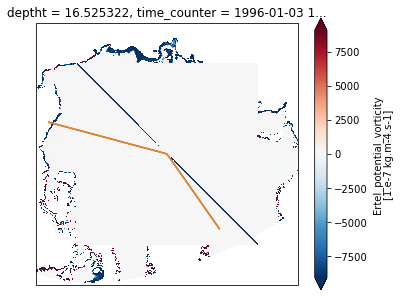

In [94]:

fig = plt.figure(figsize=(20, 5))

ax1 = fig.add_subplot(1, 3, 1, projection=ccrs.NorthPolarStereo(-45))

PVORT_REF.vototvor.isel(time_counter=0).plot(x='nav_lon',y='nav_lat',transform=ccrs.PlateCarree(), robust=True)

plt.plot(diag_transect_REF.nav_lon, diag_transect_REF.nav_lat, transform=ccrs.PlateCarree())
plt.plot([-150,-150,-10,-10],[70,90,90,75],transform=ccrs.PlateCarree())

#ax1.set_extent([-180, 360, 60, 90])

[map_config(ax) for ax in [ax1]]

In [95]:
data2plot_REF = diag_transect_REF.vototvor.mean('time_counter').isel(deptht=slice(0,40)).compute()

/opt/linux/envs/envs/phyocean-2021.05/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [ ]:
data2plot_FUT = diag_transect_FUT.vototvor.mean('time_counter').isel(deptht=slice(0,40)).compute()

(250.0, 350.0)

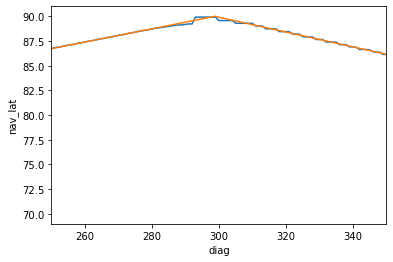

In [97]:
data2plot_REF.nav_lat.plot()
plt.plot(lat_points)
plt.xlim(250, 350)

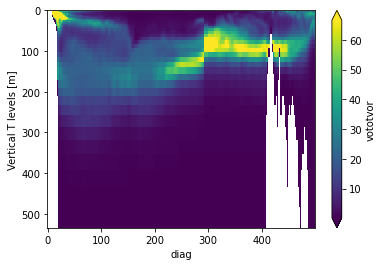

In [98]:
data2plot_REF.plot(yincrease=False, robust=True)

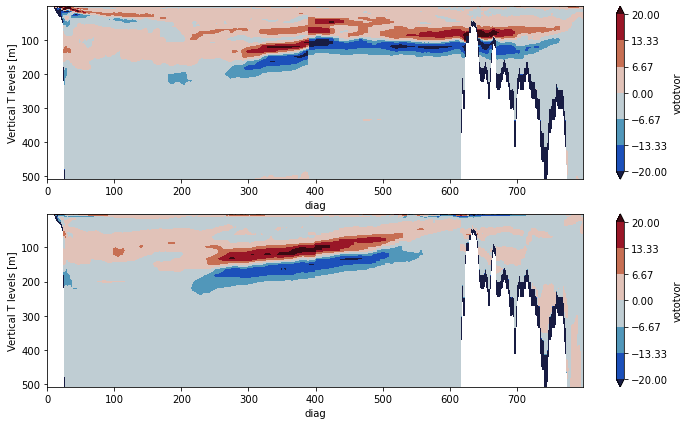

In [74]:
fig = plt.figure(figsize=(12, 7))

ax1 = fig.add_subplot(2, 1, 1)
data2plot_REF.diff('deptht').plot.contourf(ax=ax1,vmin=-20,vmax=20,cmap=cmo.balance)


ax2 = fig.add_subplot(2, 1, 2)
data2plot_FUT.diff('deptht').plot.contourf(ax=ax2,vmin=-20,vmax=20,cmap=cmo.balance)

ax1.invert_yaxis()
ax2.invert_yaxis()

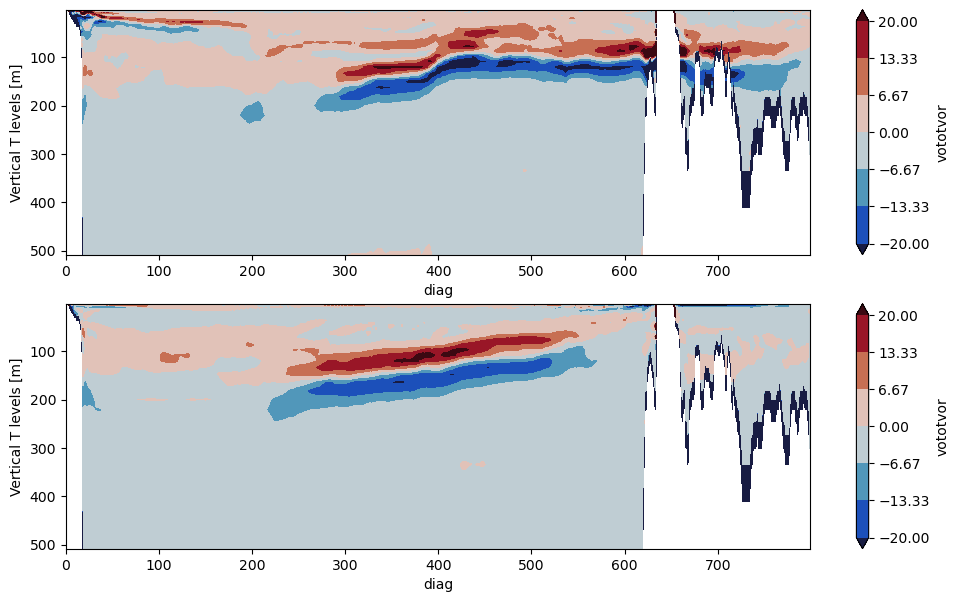

In [116]:
fig = plt.figure(figsize=(12, 7))

ax1 = fig.add_subplot(2, 1, 1)
data2plot_REF.diff('deptht').plot.contourf(ax=ax1,vmin=-20,vmax=20,cmap=cmo.balance)


ax2 = fig.add_subplot(2, 1, 2)
data2plot_FUT.diff('deptht').plot.contourf(ax=ax2,vmin=-20,vmax=20,cmap=cmo.balance)

ax1.invert_yaxis()
ax2.invert_yaxis()